In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import linearsolve as ls
%matplotlib inline

# New-Keynesian Model

This program verifies the math underlying the interactive simulation of the new-Keynesian model: https://www.briancjenkins.com/simulations/nk.html



## Equilibrium Conditions

The equilibrium conditions of the new-Keynesian model:

\begin{align}
y_{t} & = E_ty_{t+1} - \frac{1}{\sigma} r_t + g_t\\
\pi_t & = \beta E_t\pi_{t+1} + \kappa y_t + u_t\\
i_t & = \phi_{\pi} \pi_t + \phi_y y_t + v_t\\
r_t & = i_t - E_t \pi_{t+1}\\
g_{t+1} & = \rho_g g_{t} + \epsilon^g_{t+1}\\
u_{t+1} & = \rho_u u_{t} + \epsilon^u_{t+1}\\
v_{t+1} & = \rho_v v_{t} + \epsilon^v_{t+1}
\end{align}

## Analytic Solution

The model's endogenous variables as functions of exogenous state variables:

\begin{align}
y_{t} & = a_1g_t + a_2u_t + a_3v_t\\
\pi_{t} & = b_1g_t + b_2u_t + b_3v_t\\
i_{t} & = c_1g_t + c_2u_t + c_3v_t\\
r_{t} & = d_1g_t + d_2u_t + d_3v_t
\end{align}

where:

\begin{align}
a_1 & = \frac{1-\beta\rho_g}{(1-\beta\rho_g)(1-\rho_g+\sigma^{-1}\phi_y)+ \sigma^{-1}\kappa(\phi_{\pi}-\rho_g)}\\
a_2 & = -\frac{\sigma^{-1}(\phi_{\pi} - \rho_u)}{(1-\beta\rho_u)(1-\rho_u+\sigma^{-1}\phi_y)+ \sigma^{-1}\kappa(\phi_{\pi}-\rho_u)}\\
a_3 & = -\frac{\sigma^{-1}(1-\beta\rho_v)}{(1-\beta\rho_v)(1-\rho_v+\sigma^{-1}\phi_y)+ \sigma^{-1}\kappa(\phi_{\pi}-\rho_v)}
\end{align}

and:

\begin{align}
b_1 & = \frac{\kappa}{(1-\beta\rho_g)(1-\rho_g+\sigma^{-1}\phi_y)+ \sigma^{-1}\kappa(\phi_{\pi}-\rho_g)}\\
b_2 & = \frac{1-\rho_u+\sigma^{-1}\phi_y}{(1-\beta\rho_u)(1-\rho_u+\sigma^{-1}\phi_y)+ \sigma^{-1}\kappa(\phi_{\pi}-\rho_u)}\\
b_3 & = -\frac{\sigma^{-1}\kappa}{(1-\beta\rho_v)(1-\rho_v+\sigma^{-1}\phi_y)+ \sigma^{-1}\kappa(\phi_{\pi}-\rho_v)}\\
\end{align}

and:

\begin{align}
c_1 & = \phi_ya_1 + \phi_{\pi}b_1\\
c_2 & = \phi_ya_2 + \phi_{\pi}b_2\\
c_3 & = 1+ \phi_ya_3 + \phi_{\pi}b_3\\
\end{align}

and:

\begin{align}
d_1 & = c_1 - \rho_g b_1\\
d_2 & = c_2 - \rho_u b_2\\
d_3 & = c_3 - \rho_v b_3\\
\end{align}



## Compute Solution with `linearsolve`

In [8]:
# Input model parameters
beta = np.exp(-2/100)
sigma= 1
kappa= 0.25

phi_pi= 1.5
phi_y = 0.5

rho_g = 0.25
rho_u = 0.35
rho_v = 0.5


parameters=pd.Series()
parameters.beta=beta
parameters.sigma=sigma
parameters.kappa=kappa
parameters.phi_pi=phi_pi
parameters.phi_y=phi_y
parameters.rho_g=rho_g
parameters.rho_u=rho_u
parameters.rho_v=rho_v

def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Euler equation
    euler_eqn = fwd.y -1/p.sigma*cur.r + cur.g - cur.y
    
    # NK Phillips curve
    phillips_curve = p.beta*fwd.pi + p.kappa*cur.y + cur.u - cur.pi
    
    # Interest rate rule for monetary policy
    interest_rule = p.phi_y*cur.y+p.phi_pi*cur.pi + cur.v - cur.i
    
    # Fisher equation
    fisher_eqn = cur.i - fwd.pi - cur.r
    
    # Exogenous demand
    g_proc =  p.rho_g*cur.g - fwd.g
    
    # Exogenous inflation
    u_proc =  p.rho_u*cur.u - fwd.u
    
    # Exogenous monetary policy
    v_proc =  p.rho_v*cur.v - fwd.v
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            euler_eqn,
            phillips_curve,
            interest_rule,
            fisher_eqn,
            g_proc,
            u_proc,
            v_proc
        ])

# Initialize the nk
nk = ls.model(equilibrium_equations,
              nstates=3,
              varNames=['g','u','v','i','r','y','pi'],
              parameters=parameters)

# Set the steady state of the nk
nk.set_ss([0,0,0,0,0,0,0])

# Find the log-linear approximation around the non-stochastic steady state
nk.approximate_and_solve(loglinear=False)

# Solve the nk
nk.solve_klein(nk.a,nk.b)

## Compute Solution Directly

In [9]:
a1=(1-beta*rho_g)/((1-beta*rho_g)*(1-rho_g+phi_y/sigma)+kappa/sigma*(phi_pi-rho_g))
a2=-(phi_pi-rho_u)/sigma/((1-beta*rho_u)*(1-rho_u+phi_y/sigma)+kappa/sigma*(phi_pi-rho_u))
a3=-(1-beta*rho_v)/sigma/((1-beta*rho_v)*(1-rho_v+phi_y/sigma)+kappa/sigma*(phi_pi-rho_v))

b1=kappa/((1-beta*rho_g)*(1-rho_g+phi_y/sigma)+kappa/sigma*(phi_pi-rho_g))
b2=(1-rho_u+phi_y/sigma)/((1-beta*rho_u)*(1-rho_u+phi_y/sigma)+kappa/sigma*(phi_pi-rho_u))
b3=-kappa/sigma/((1-beta*rho_v)*(1-rho_v+phi_y/sigma)+kappa/sigma*(phi_pi-rho_v))

c1=phi_y*a1+phi_pi*b1
c2=phi_y*a2+phi_pi*b2
c3=phi_y*a3+phi_pi*b3+1

d1=c1-rho_g*b1
d2=c2-rho_u*b2
d3=c3-rho_v*b3

## Compare Analytic and Numeric Solutions

In [10]:
print('verify a1,a2, a3:')
print(a1-nk.f[2,0])
print(a2-nk.f[2,1])
print(a3-nk.f[2,2])

print('\n')
print('verify b1,b2, b3:')
print(b1-nk.f[3,0])
print(b2-nk.f[3,1])
print(b3-nk.f[3,2])

print('\n')
print('verify c1,c2, c3:')
print(c1-nk.f[0,0])
print(c2-nk.f[0,1])
print(c3-nk.f[0,2])

print('\n')
print('verify d1,d2, d3:')
print(d1-nk.f[1,0])
print(d2-nk.f[1,1])
print(d3-nk.f[1,2])

verify a1,a2, a3:
-6.661338147750939e-16
2.220446049250313e-15
9.992007221626409e-16


verify b1,b2, b3:
3.3306690738754696e-16
-6.661338147750939e-16
-5.551115123125783e-17


verify c1,c2, c3:
5.551115123125783e-16
-1.7763568394002505e-15
8.326672684688674e-17


verify d1,d2, d3:
5.551115123125783e-16
-1.7763568394002505e-15
-2.7755575615628914e-16


## Plot Simulations

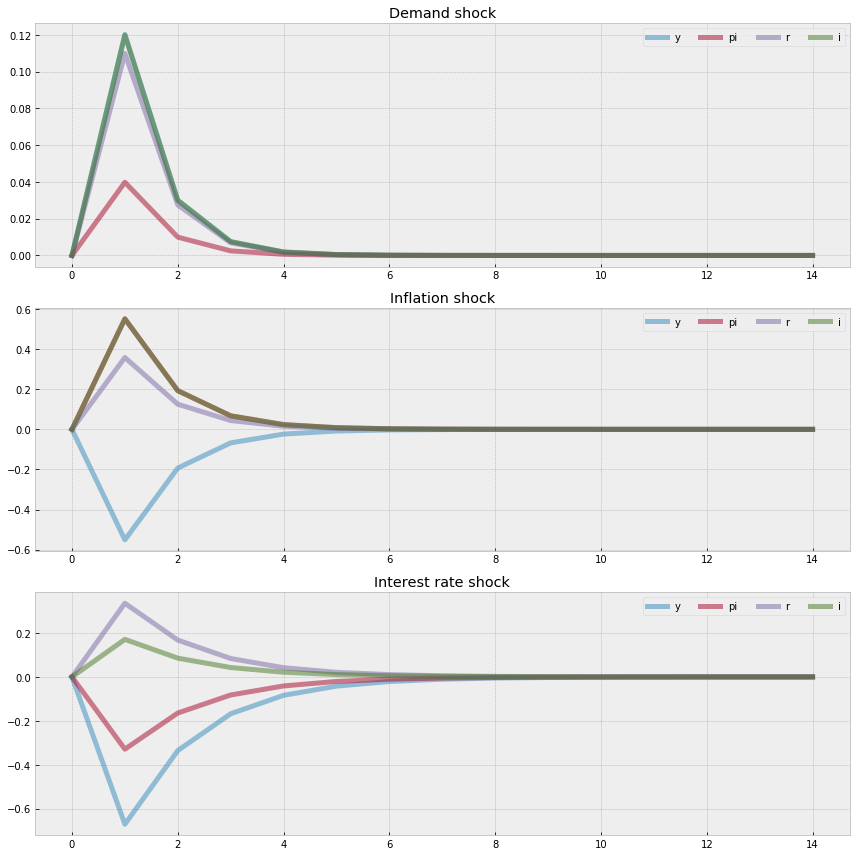

In [12]:
# Compute impulse responses and plot
nk.impulse(T=15,t0=1,shocks=[0.2,0.5,1])

# Create the figure and axes
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

# Plot commands
nk.irs['e_g'][['y','pi','r','i']].plot(lw='5',alpha=0.5,grid=True,title='Demand shock',ax=ax1).legend(loc='upper right',ncol=5)
nk.irs['e_u'][['y','pi','r','i']].plot(lw='5',alpha=0.5,grid=True,title='Inflation shock',ax=ax2).legend(loc='upper right',ncol=5)
nk.irs['e_v'][['y','pi','r','i']].plot(lw='5',alpha=0.5,grid=True,title='Interest rate shock',ax=ax3).legend(loc='upper right',ncol=5)

fig.tight_layout()
